Análisis de publicaciones sobre analytics y big data en Scopus
===

En este tutorial se ejemplifica la realización del análisis exploratorio de datos aplicado a las revistas listadas en Scopus que contienen en sus nombres las palabras *big data*, *data science*, *business intelligence* y *analitics*.

In [1]:
##
## Preparacion
##
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Descripción de la información

El archivo `scopus-papers.csv` contiene la información bibliográfica de los artículos seleccionados. Los nombres de las columnas son autoexplicativos.

## Carga de la información

In [2]:
##
## Lectura de datos
##
papers = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/playground/master/datasets/scopus-papers.csv",
    sep=",",  # separador de campos
    thousands=None,  # separador de miles para números
    decimal=".",  # separador de los decimales para números
    encoding="latin-1",
)  # idioma
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ï»¿Authors                 1902 non-null   object 
 1   Author(s) ID               1902 non-null   object 
 2   Title                      1902 non-null   object 
 3   Year                       1902 non-null   int64  
 4   Source title               1902 non-null   object 
 5   Volume                     1860 non-null   float64
 6   Issue                      1456 non-null   object 
 7   Art. No.                   531 non-null    object 
 8   Page start                 1411 non-null   object 
 9   Page end                   1411 non-null   object 
 10  Page count                 2 non-null      float64
 11  Cited by                   1257 non-null   float64
 12  DOI                        1825 non-null   object 
 13  Link                       1902 non-null   objec

## Nombres de las revistas

In [3]:
papers["Source title"].drop_duplicates().sort_values(ascending=True)

123                           Applied Marketing Analytics
74                                               Big Data
57                                      Big Data Research
744                                              Big data
111                                  Data Science Journal
82                           Data Science and Engineering
0                                        EPJ Data Science
1901    Easy Care in Wool; Woolmark Business Intellige...
88      Environment and Planning B: Urban Analytics an...
65            International Journal of Business Analytics
417     International Journal of Business Intelligence...
147     International Journal of Business Intelligence...
17                                    Journal of Big Data
61                        Journal of Management Analytics
70                         Journal of Marketing Analytics
1900    World Wool Supply to 2005; Woolmark Business I...
Name: Source title, dtype: object

In [4]:
##
## Cantidad de revistas
##
papers["Source title"].drop_duplicates().count()

16

## Cantidad de citas por año por revista

In [5]:
df = (
    papers.groupby(["Source title"])
    .sum()[["Cited by"]]
    .sort_values("Cited by", ascending=False)
)
df

,Cited by
Source title,
Journal of Big Data,2312.0
EPJ Data Science,1902.0
Data Science Journal,1468.0
International Journal of Business Intelligence and Data Mining,1420.0
Big Data,1164.0
Big Data Research,926.0
Journal of Management Analytics,440.0
Environment and Planning B: Urban Analytics and City Science,370.0
Journal of Marketing Analytics,253.0


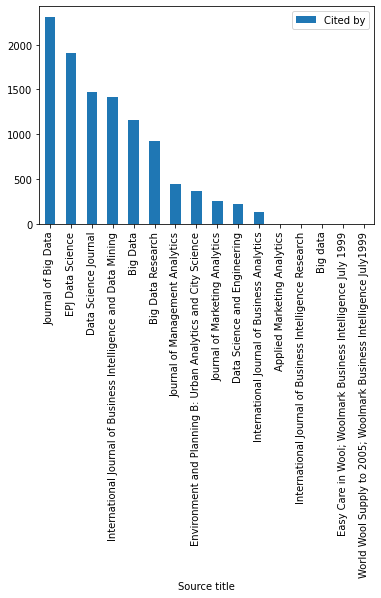

In [6]:
##
## Gráfico por defecto usando Matplotlib
##
df.plot.bar()

In [7]:
##
## Gráfico usando Altair
##
import altair as alt

df["Source title"] = [p for p in df.index]
alt.Chart(df).mark_bar().encode(
    y=alt.Y("Source title:N", sort=alt.EncodingSortField(field="Cited by:Q")),
    x="Cited by:Q",
    color="Cited by:Q",
)

alt.Chart(...)

## Total de citas por año

In [8]:
##
## Suma de citas agregada por título y año
##
papers.groupby(["Source title", "Year"], as_index=True).sum()[["Cited by"]]

Cited by
Source title                                       Year          
Applied Marketing Analytics                        2018       2.0
                                                   2019       0.0
Big Data                                           2013     543.0
                                                   2014     170.0
                                                   2015     203.0
...                                                           ...
Journal of Marketing Analytics                     2016      12.0
                                                   2017       5.0
                                                   2018       7.0
                                                   2019       0.0
World Wool Supply to 2005; Woolmark Business In... 1999       0.0

[89 rows x 1 columns]

In [9]:
#
# Los ejes para la gráfica deben ser campos
# en el DataFrame
#
df = papers.groupby(["Source title", "Year"], as_index=False).sum()[["Source title", "Year", "Cited by"]]
df

,Source title,Year,Cited by
0,Applied Marketing Analytics,2018,2.0
1,Applied Marketing Analytics,2019,0.0
2,Big Data,2013,543.0
3,Big Data,2014,170.0
4,Big Data,2015,203.0
...,...,...,...
84,Journal of Marketing Analytics,2016,12.0
85,Journal of Marketing Analytics,2017,5.0
86,Journal of Marketing Analytics,2018,7.0
87,Journal of Marketing Analytics,2019,0.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


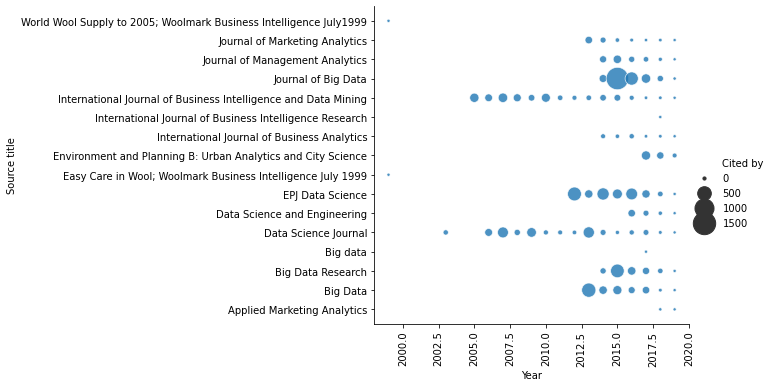

In [10]:
#
# Gráfica usando seaborn
#
import seaborn as sns

sns.relplot(
    x = 'Year',
    y = 'Source title',
    size = 'Cited by',
    sizes = (10, 500),
    alpha = 0.8,
    palette = 'viridis',
    data = df);
plt.xticks(rotation=90);

In [11]:
#
# Usando Altair
#
alt.Chart(df).mark_circle().encode(
    alt.X(
        "Year:Q", scale=alt.Scale(domain=(2002, 2019)), axis=alt.Axis(labelAngle=270)
    ),
    alt.Y("Source title:N"),
    size="Cited by",
    color="Cited by",
)

alt.Chart(...)

## Palabras claves más frecuentes

In [12]:
#
# 1.-- Elimina los registros con valor NaN
#      words es un objeto pandas.Series
#
words = papers["Author Keywords"].dropna()
type(words)

pandas.core.series.Series

In [13]:
words.head()

0    Geo-location data; Human mobility; Resilience;...
1    Language analysis; LIWC; Moral foundations the...
2    Gravity model; Media ecosystem; News spreading...
3    Centrality measures; Community Structure; Infl...
4    Cholesterol; Diabetes; Digital purchase record...
Name: Author Keywords, dtype: object

In [14]:
#
# 2.-- Parte las cadenas por el ';'
#
words = words.map(lambda w: w.split(';'))
words.head()

0    [Geo-location data,  Human mobility,  Resilien...
1    [Language analysis,  LIWC,  Moral foundations ...
2    [Gravity model,  Media ecosystem,  News spread...
3    [Centrality measures,  Community Structure,  I...
4    [Cholesterol,  Diabetes,  Digital purchase rec...
Name: Author Keywords, dtype: object

In [15]:
# 
# 3.-- Elimina los espacios en blanco al principio y
#      final de cada palabra clave y convierte la
#      cadena en minúsculas
#
words = words.map(lambda w: [p.strip().lower() for p in w])
words.head()

0    [geo-location data, human mobility, resilience...
1    [language analysis, liwc, moral foundations th...
2    [gravity model, media ecosystem, news spreadin...
3    [centrality measures, community structure, inf...
4    [cholesterol, diabetes, digital purchase recor...
Name: Author Keywords, dtype: object

In [16]:
#
# 3.-- Genera un registro por cada palabra clave
#
words = words.explode()
words.head()

0    geo-location data
0       human mobility
0           resilience
0         social media
1    language analysis
Name: Author Keywords, dtype: object

In [17]:
#
# 4.-- Cuenta las palabras clave.
#      Este es a pandas.Series con las palabras clave
#      como indices
#
words = words.value_counts()
words

big data                    167
data mining                 134
machine learning             57
clustering                   41
big data analytics           37
                           ... 
in-game probabilities         1
quality policy                1
salespeople                   1
hierarchical information      1
geoprocessing                 1
Name: Author Keywords, Length: 6368, dtype: int64

In [18]:
#
# 5.-- Top palabras más usadas
#
words = words.sort_values(ascending=False)
words.head(10)

big data                 167
data mining              134
machine learning          57
clustering                41
big data analytics        37
classification            33
business intelligence     31
metadata                  30
social media              29
mapreduce                 26
Name: Author Keywords, dtype: int64

In [19]:
#
# 6.-- Para usar Altair es necesario convertir 
#      el objeto pandas.Series en un pandas.DataFrame
#
words = words.to_frame()
words

,Author Keywords
big data,167
data mining,134
machine learning,57
clustering,41
big data analytics,37
...,...
associative classifier,1
goodness-of-fit test,1
space geodesy,1
social mining,1


In [20]:
#
# 7.-- Se transforma el indice en una columna
#      del dataframe
#
words = words.reset_index()
words

,index,Author Keywords
0,big data,167
1,data mining,134
2,machine learning,57
3,clustering,41
4,big data analytics,37
...,...,...
6363,associative classifier,1
6364,goodness-of-fit test,1
6365,space geodesy,1
6366,social mining,1


In [21]:
alt.Chart(words[0:20]).mark_bar().encode(
    x="Author Keywords:Q", 
    y=alt.Y("index:N", 
            sort=alt.EncodingSortField(field="index:Q")), 
    color="Author Keywords:Q"
)

alt.Chart(...)

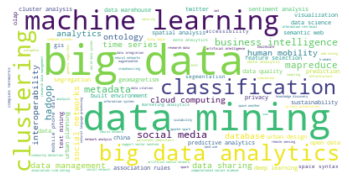

In [22]:
#
# 8.-- Wordcloud
#
from wordcloud import ImageColorGenerator, WordCloud

words_dic = {key: value   for key, value in zip(words['index'], words['Author Keywords'])}

wordcloud = WordCloud(
    max_font_size=50, max_words=100, background_color="white"
).generate_from_frequencies(words_dic)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Contribuciones por país de origen

Uno de los gráficos comúnmente usados en los mapeos sistemáticos de literatura es la cantidad de artículos por país de origen. Este gráfico da una idea de en que lugares se está concentrando la investigación sobre el tópico abordado. A continuación se describe el código para este gráfico.

In [23]:
#
# 1.-- Borra NA
#
affiliations = papers["Affiliations"].dropna()

In [24]:
#
# 2.-- Obtiene la afiliación por autor
#
affiliations = affiliations.map(lambda w: w.split(';'))
affiliations

0       [Department of Civil, Environmental, and Const...
1       [Empirical Studies of Conflict Project, Woodro...
2       [L3S Research Center, Leibniz-University, Hann...
3       [LRIT URAC No 29, Faculty of Science, Rabat IT...
4       [Nokia Bell Labs, Cambridge, United Kingdom,  ...
                              ...                        
1895    [Institute of Geodesy and Cartography, ul. Jas...
1896    [Dept of Geography and Human Environment, Envi...
1897    [ESPACE, UMR 6012, CNRS, 74, rue Louis Pasteur...
1898    [Centre for Geo-Information, Wageningen UR, PO...
1899    [Institute for Geoinformatics, University of M...
Name: Affiliations, Length: 1889, dtype: object

In [25]:
#
# 3.-- Ejemplo de una afiliacion
#
affiliations[0]

['Department of Civil, Environmental, and Construction Engineering, University of Central Florida, Orlando, United States',
 ' Media Laboratory, Massachusetts Institute of Technology, Cambridge, United States']

In [26]:
#
# 4.-- Extrae el nombre del país (ultima posición)
#
affiliations = affiliations.map(lambda w: [x.split(',')[-1].strip()   for x in w])
affiliations

0                          [United States, United States]
1       [United States, Qatar, United States, United S...
2                          [Germany, Chile, Chile, Italy]
3                               [Morocco, France, France]
4       [United Kingdom, Italy, United Kingdom, United...
                              ...                        
1895                                             [Poland]
1896                                             [Israel]
1897                                             [France]
1898                             [Netherlands, Australia]
1899                                   [Germany, Germany]
Name: Affiliations, Length: 1889, dtype: object

In [28]:
#
# 5.-- Expande la columna
#
affiliations = affiliations.explode()
affiliations

0       United States
0       United States
1       United States
1               Qatar
1       United States
            ...      
1897           France
1898      Netherlands
1898        Australia
1899          Germany
1899          Germany
Name: Affiliations, Length: 3963, dtype: object

In [42]:
#
# 6.-- Cuenta las ocurrencias de cada país
#
affiliations = affiliations.value_counts()
affiliations

United States                             1089
China                                      457
India                                      295
United Kingdom                             250
Japan                                      239
                                          ... 
CASS                                         1
Namibia                                      1
Amman                                        1
Open Culture International Association       1
Croatia                                      1
Name: Affiliations, Length: 101, dtype: int64

In [47]:
#
# 7.-- Worldmap
#
!curl -0 https://raw.githubusercontent.com/jdvelasq/playground/master/datasets/worldmap.data > worldmap.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  361k  100  361k    0     0  1127k      0 --:--:-- --:--:-- --:--:-- 1127k


In [48]:
import matplotlib

def worldmap(
    x, cmap="Pastel2", figsize=(6, 6), legend=True, fontsize=11, *args, **kwargs,
):
    
    matplotlib.rc("font", size=fontsize)
    fig = plt.Figure(figsize=figsize)
    ax = fig.subplots()
    cmap = plt.cm.get_cmap(cmap)

    df = x.to_frame()

    df["color"] = x.map(lambda w: 0.1 + 0.9 * (w - x.min()) / (x.max() - x.min()))

    with open("worldmap.data", "r") as f:
        countries = json.load(f)
    
    for country in countries.keys():
        data = countries[country]
        for item in data:
            ax.plot(item[0], item[1], "-k", linewidth=0.5)
            if country in x.index.tolist():
                ax.fill(item[0], item[1], color=cmap(df.color[country]))
    #
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xleft = xmax - 0.02 * (xmax - xmin)
    xright = xmax
    xbar = np.linspace(xleft, xright, 10)
    ybar = np.linspace(ymin, ymin + (ymax - ymin), 100)
    xv, yv = np.meshgrid(xbar, ybar)
    z = yv / (ymax - ymin) - ymin
    ax.pcolormesh(xv, yv, z, cmap=cmap)
    #
    pos = np.linspace(ymin, ymin + (ymax - ymin), 11)
    value = [round(x.min() + (x.max() - x.min()) * i / 10, 0) for i in range(11)]
    for i in range(11):
        ax.text(
            xright + 0.4 * (xright - xleft),
            pos[i],
            str(int(value[i])),
            ha="left",
            va="center",
        )

    ax.plot(
        [xleft - 0.1 * (xright - xleft), xleft - 0.1 * (xright - xleft)],
        [ymin, ymax],
        color="gray",
        linewidth=1,
    )
    for i in range(11):
        ax.plot(
            [xleft - 0.0 * (xright - xleft), xright],
            [pos[i], pos[i]],
            linewidth=2.0,
            color=cmap((11 - i) / 11),
        )

    ax.set_aspect("equal")
    ax.axis("on")
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines["bottom"].set_color("gray")
    ax.spines["top"].set_color("gray")
    ax.spines["right"].set_color("gray")
    ax.spines["left"].set_color("gray")

    fig.set_tight_layout(True)

    return fig

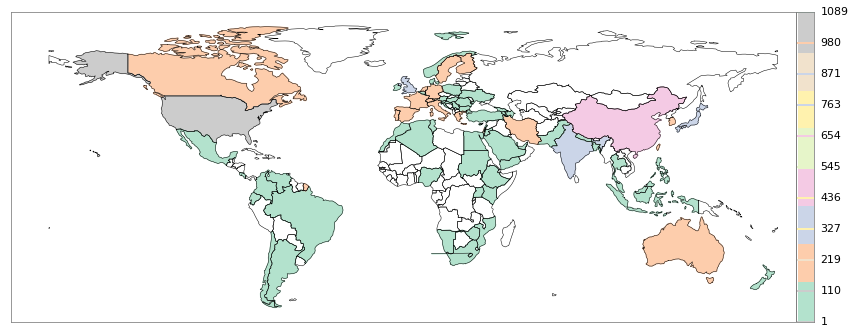

In [53]:
worldmap(affiliations, figsize=(12, 8))